AVHRR Remote Sensed Temperature
==

CenCOOS:
 Links to 1-day composite and 8-day composite

 [CenCOOS Page for AVHRR 1-day Composite](https://data.caloos.org/?ls=5bc19960-56e2-9257-d001-c050a9b7afc8#module-metadata/1f22a216-2565-11e3-8377-00219bfe5678/ca8a20b9-99aa-4617-b22a-848e83ac0ac7)



Other sources:


In [1]:
%matplotlib widget

In [20]:
import xarray as xr
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
from scipy import sparse

from stompy.plot.plot_utils import pad_pcolormesh
from stompy.plot import plot_wkb
from stompy.grid import unstructured_grid
from stompy.io.local import usgs_nwis
import os
import six
from shapely import geometry, prepared
from stompy.spatial import proj_utils
from stompy import utils
import temp_utils
import pandas as pd

In [15]:
# Get a full bay grid for plotting
grid=unstructured_grid.UnstructuredGrid.read_dfm("../bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_net.nc")
grid_poly = grid.boundary_polygon()
grid_ll = grid.reproject('EPSG:26910','WGS84')
grid_ll_poly = grid_ll.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249216, 15 potential interiors
INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=0.328930, 15 potential interiors


In [4]:
ds=temp_utils.fetch_or_load_daily_avhrr_cropped()

In [5]:
from shapely import wkt
ocean_wkt="""
Polygon ((497439.6 4204573.2, 500803.7 4215309.0, 503074.4 4222492.0, 499026.5 4232025.6, 492917.8 4240079.7, 491638.7 4241945.3, 492429.8 4245083.5, 486930.7 4254892.2, 382169.9 4255548.9, 379645.8 4108476.2, 555487.7 4107999.5, 549417.6 4118524.6, 549745.6 4130667.5, 546699.6 4139595.3, 539648.5 4153851.3, 497439.6 4204573.2))
"""
ocean_poly = wkt.loads(ocean_wkt)

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249216, 15 potential interiors


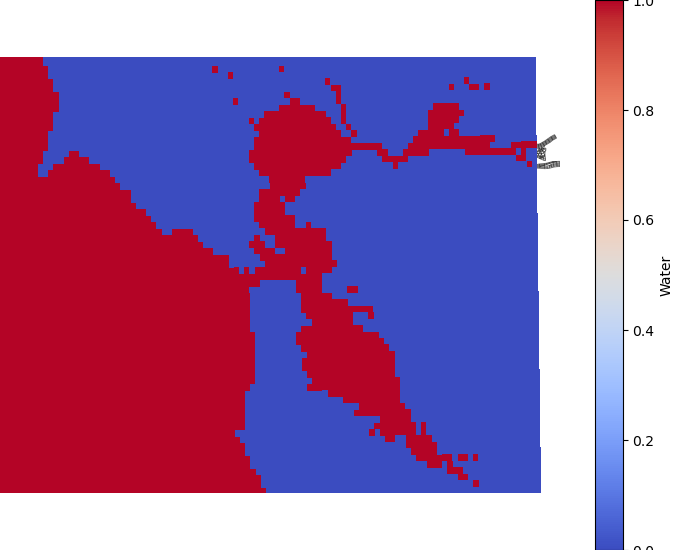

In [6]:
# Get a watermask from the grid. Add manual polygong to cover more 
# offshore areas in case there is relevant information out there
six.moves.reload_module(temp_utils)
temp_utils.add_watermask(ds,grid,extra_poly=ocean_poly)

fig,ax=plt.subplots(figsize=(7.0,5.5))
coll=pad_pcolormesh( ds.x, ds.y, ds.water, cmap='coolwarm',zorder=2, ax=ax)
grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.6,zorder=0)
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
plt.colorbar(coll,label='Water')

In [8]:
# test round trip of water indexing:
def wet_recon(wet_data):
    d=np.full( (ds.dims['latitude'], ds.dims['longitude']), np.nan)
    d[ds.water] = wet_data
    return d
    
if 0:
    data=ds.sst.isel(time=35)
    wet_data=data.values[ds.water.values]
    
    # using numpy broadcasting:
    dA=wet_recon(wet_data)
    
    # manual:
    dB=np.full( (ds.dims['latitude'], ds.dims['longitude']), np.nan)
    for ll in np.ndindex( ds.water.shape ):
        wet_index=ds.water_index.values[ll[0],ll[1]]
        dB[ll[0],ll[1]] = wet_data[wet_index]
    
    assert np.allclose(dA,dB,equal_nan=True)

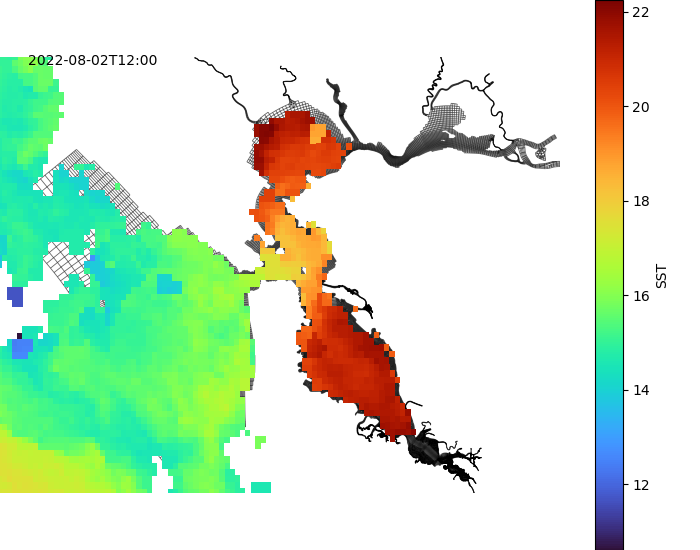

In [9]:
ds=temp_utils.fetch_or_load_daily_avhrr_cropped()
fig,ax=plt.subplots(figsize=(7.0,5.5))

# tidx=31, 8/2 is great.
tidx=31
coll=pad_pcolormesh( ds.x, ds.y, ds.sst.isel(time=tidx), cmap='turbo',zorder=2,ax=ax)

grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.6,zorder=0)
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
plt.colorbar(coll,label='SST')
ax.text(0.05, 0.98,str(ds.time.values[tidx])[:16],transform=ax.transAxes) ;

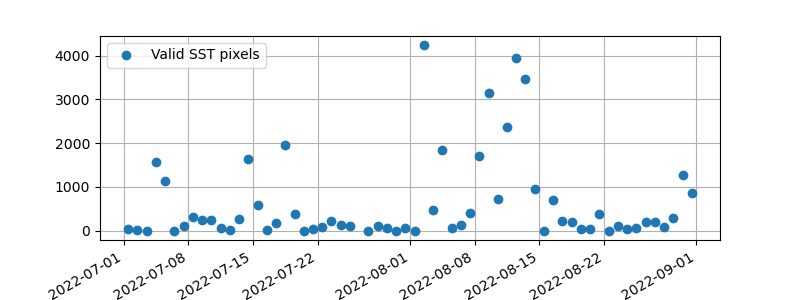

In [10]:
fig,ax=plt.subplots(figsize=(8,3))
ax.plot( ds.time, ds.sst.notnull().sum(dim=['latitude','longitude']), label='Valid SST pixels',marker='o',lw=0)
ax.legend(loc='upper left')
fig.autofmt_xdate()
ax.grid()

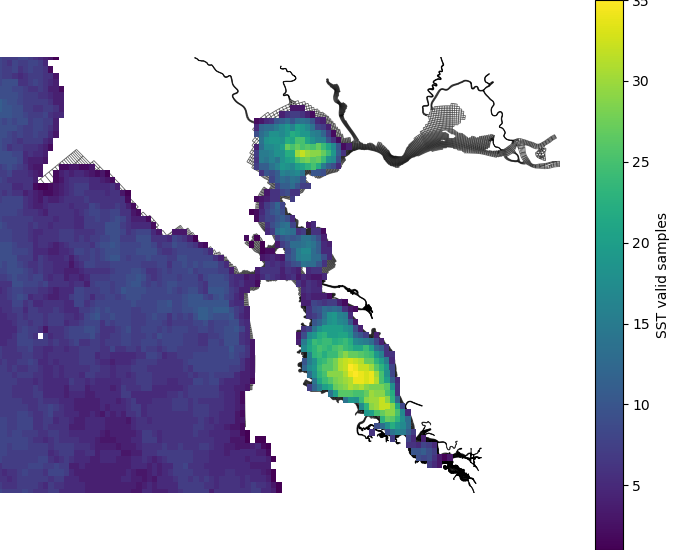

In [11]:
# Samples per pixel
fig,ax=plt.subplots(figsize=(7.0,5.5))

counts=ds.sst.notnull().sum(dim='time').values.astype(np.float64)
counts[ counts==0]= np.nan

coll=pad_pcolormesh( ds.x, ds.y, counts,zorder=2,ax=ax)

grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.6,zorder=0)
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
plt.colorbar(coll,label='SST valid samples') ;

In [17]:
# What's a reasonable way to fill?
# Some combination of 
#  * temporal autocorrelation
#  * generic (distance-based) spatial autocorrelation
#  * specific (covariance-based) spatial autocorrelation -- gets expensive.

# Can operate on the whole stack

In [20]:
# ~2000 water pixels.
# precomputed covariance matrix will take 4M entries. Storage is no
# problem, but naive computation is.

def compute_pixel_correlation(ds,rho=0.9974):
    Nwater = ds.water.values.sum()
    adj = sparse.dok_matrix( (Nwater,Nwater), dtype=np.float64)
    
    water=ds.water.values
    water_ll_idx = ds.water_ll_idx.values # linear => row,col
    water_idx = ds.water_index.values # row,col => linear
    
    # adj_decorr=0.1 # 0.05 is the "empirical" choice, but feels too small
    # calculating the correlation between adjacent pixels, get ~ rho=0.997
    # To chain that, I want negative log.
    adj_nlog_corr=-np.log(rho) 
    
    for wetA in range(Nwater):
        A_ll=water_ll_idx[wetA]
    
        for nbr in [[0,1], [1,0], [1,1], [1,-1]]: # east, north, northeast, southeast
            Blat=A_ll[0]+nbr[0]
            Blon=A_ll[1]+nbr[1]
            if Blat < 0 or Blon < 0: continue
            if Blat >= water.shape[0] or Blon>=water.shape[1]: continue 
            if not water[Blat, Blon]: continue
            wetB=water_idx[Blat, Blon]
            fac=np.sqrt(nbr[0]**2+nbr[1]**2)
            adj[wetA,wetB]=fac*adj_nlog_corr
            adj[wetB,wetA]=fac*adj_nlog_corr
    
    adj_csr=adj.tocsr()
    wet_nlog_corr=sparse.csgraph.floyd_warshall(adj_csr) # 5 seconds
    wet_corr=np.exp(-wet_nlog_corr)
    return wet_corr
    
wet_corr=compute_pixel_correlation(ds)

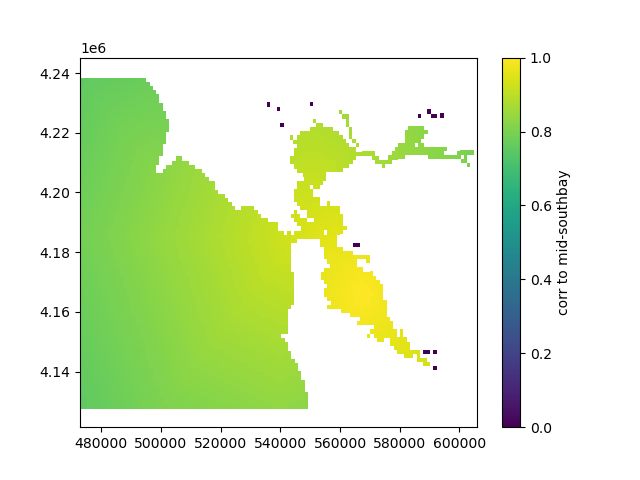

In [22]:
if 1: # Confirm that worked
    # Choose a pixel in the middle-ish.
    water_idx = ds.water_index.values 
    origin=[27,85] 
    origin_idx=water_idx[ tuple(origin) ]
    ll_dists=wet_recon(wet_corr[origin_idx,:])
    fig,ax = plt.subplots()
    coll=pad_pcolormesh( ds.x, ds.y, ll_dists,zorder=2,ax=ax)
    ax.axis('equal')
    plt.colorbar(coll,label='corr to mid-southbay')

In [23]:
def combine_covariance(mu,v,origin,covariates,plot=False,var_obs=0.1,omit_origin=True):
    """
    mu,v:  priors, used as the background field and error variance.
    origin: wet index of the origin
    covariates: [ (fake distance, wet_index, value), ... ]

    if origin is also in covariates, it must be the first entry.

    omit_origin: if origin is *not* in covariates, drop the background mu from the
    weights, renormalize.
    """
    # sort of a hack. Really should be using a different form of OI that does not
    # assume we have a background model.
    origin_has_data=covariates[0,1]==origin

    if origin_has_data:
        all_idxs = covariates[:,1].astype(int)    
        all_corr=wet_corr[all_idxs,:][:,all_idxs]
        obs_means=covariates[:,2]
        obs_variance = var_obs*np.ones(len(covariates))
    else:
        all_idxs = [ origin ] + list( covariates[:,1].astype(int))    
        all_corr=wet_corr[all_idxs,:][:,all_idxs]
        obs_means=np.r_[mu, covariates[:,2]] # Fake observation at origin.
        obs_variance = np.r_[100*v,var_obs*np.ones(len(covariates))]
        
    # error covariance for observations assumes no correlation, just the error variance for each.
    # First entry we have no data, so either v, or something else really large.
    # Could be worthwhile to allow for error covariance in the observations. RS scenes seem to 
    # sometimes have a patch (cloud?) that has bad data. 

    # https://www.atmosp.physics.utoronto.ca/PHY2509/ch3.pdf
    
    # mu,v, the priors, are taken as the "background" field in OI terms.
    # This could be expanded at some point to account for long-term mean temp
    # or a proper model output. For present purposes, I just want it to be a
    # spatially uniform, fairly uninformative prior.
    
    background_mu =np.full( len(all_corr), mu)
    
    # error covariance for the background field.
    Pb = v * all_corr
        
    R=np.diag(obs_variance)

    R_Pb_inv = np.linalg.inv(R + Pb)
    W = Pb @ R_Pb_inv
    
    # For the present use case the math could be streamlined, since we don't
    # have a real background field or an observation at the origin.
    # but it doesn't really hurt, and keeps the method intact for future use.
    
    if plot:
        fig,ax=plt.subplots()
        labels=[ f"{i}" for i in all_idxs]
        sns.heatmap(W,annot=True, xticklabels=labels, yticklabels=labels)
        
        fig,ax=plt.subplots()
        labels=[ f"{i}" for i in all_idxs]
        sns.heatmap(all_corr,annot=True, xticklabels=labels, yticklabels=labels)

    weights=W[0,:] # just the first row for constructing the tgt_idx
    
    if origin_has_data or not omit_origin:
        result = background_mu[0] + weights.dot( obs_means - background_mu)
    else:
        # only use weights for actual observations
        # the uncertainty estimate is not changed, though. Will not be 100%
        # consistent
        if weights[1:].sum()<=0:
            import pdb
            pdb.set_trace()
        weights = weights[1:] / weights[1:].sum()
        result = background_mu[0] + weights.dot( obs_means[1:] - background_mu[1:])
            
    # still need a variance estimate
    # This is from the first section of the PDF
    Pa = R@R_Pb_inv@Pb

    # While it shouldn't be possible for this to go negative, some combination of
    # ill-conditioned matrices, not-quite-exact covariances, or programmer naivete
    # allows slightly negative variances on occasion. Similarly, it's possible
    # for some weights to be slightly negative, but so far that has not been
    # a major issue.
    result_var=max(0,Pa[0,0])

    # The OI section introduces an observation projection H. If I take that to be
    # the identity, can use their simpler expression for Pa, get same value.
    # Pa = (np.eye(len(all_corr))-W)@Pb
    return result,result_var


In [24]:
# Start with just the space component:
# decorrelation in space, for now assuming global mean, scales are all the same.
# so we can deal directly with variance.
# Break it down to figuring out one pixel at one time

def spatial_autocorr(wet_tgt_idx,wet_observations,max_steps=60,max_covariates=80,var_obs=0.1,
                     background_mu=15.0, background_var=10.0**2,plot=False):
    """
    covariance is deduced from wet_corr
    combine:
      'simple': assume correlates are independent. 
      'covariance' account for covariance.
    """
    # Initial approach:
    # Breadth-first search for cells with valid values, out to some threshold of variance.

    # Then use what is essentially weighted least-squares to estimate a value and variance based
    # on the covariates with known data. In the initial approach this is done iteratively, updating
    # mu,sigma^2 with one covariate at at ime. That inherently assumes that covariates are independent,
    # which is a bad assumption.
    # The variances that come out of this are unfortunately underestimates, given that there is a lot of
    # correlation between the covariates.
    
    # For example, point A might decorrelate from B by 1 degC^2, and from C by 1 degC^2.
    # If B and C are actually perfectly correlated, then the information from C does not actually
    # improve our estimate of A.

    # First refinement: use the same set of correlates, but account for covariance when combining.

    # use the correlation matrix to grab good candidates
    wet_data_idxs = np.nonzero(np.isfinite(wet_observations))[0] # wet indices with data.
    
    correlations=wet_corr[wet_tgt_idx,wet_data_idxs] # correlation coefficient between target pixel and valid wet pixels.
    sources = wet_data_idxs[ np.argsort(-correlations) ] 
    sources=sources[:max_covariates] # may not be necessary
    

    covariates=[]
    for source in sources: 
        # new code ignores the 'var' argument. Will put correlation in while debugging.
        if wet_corr[wet_tgt_idx,source]>0: # should be vectorized above
            covariates.append( [wet_corr[wet_tgt_idx,source],source, wet_observations[source]])

    covariates = np.array(covariates)
    
    # "prior"
    mu=background_mu 
    v=background_var

    if len(covariates)>0:
        mu,v = combine_covariance(mu,v,origin=wet_tgt_idx,covariates=covariates,
                                  var_obs=var_obs,plot=plot)
    return mu,v

def spatial_extrap(observed,var_obs=0.1):
    """
    Extrapolate in space by simplified optimal interpolation.
    Each pixel is handled separately, and with a limited number of observations.
    In some cases this can lead to discontinuities, where one pixel has neighbors
    in multiple directions, but an adjacent pixel has all of its neighbors
    in only one direction.
    Increasing the max_covariates helps, but not a guarantee.
    """
    est_mean=observed.copy()
    est_var =np.zeros(est_mean.shape)
    water=ds.water.values

    water_index=ds.water_index.values
    wet_observed=observed[ds.water.values] # ravel'd observations of wet pixels

    for row,col in utils.progress(np.ndindex(est_mean.shape)):
        if not water[row,col]:
            est_mean[row,col]=np.nan
            est_var[row,col]=np.nan
        #elif np.isfinite(est_mean[row,col]):
        #    est_var[row,col] = var_obs
        else:
            mu,v=spatial_autocorr(water_index[row,col],wet_observed,var_obs=var_obs,background_mu=15.0)
            est_mean[row,col]=mu
            est_var[row,col]=v
    return est_mean,est_var


In [25]:
# Show interpolation results:
sst=ds.sst.values
observed=sst[31,:,:]

est_mean,est_var = spatial_extrap(observed)

INFO:utils:128
INFO:utils:511
INFO:utils:752
INFO:utils:893
INFO:utils:1025
INFO:utils:1232
INFO:utils:1447
INFO:utils:1614
INFO:utils:1957
INFO:utils:2182
INFO:utils:2373
INFO:utils:2702
INFO:utils:2813
INFO:utils:2905
INFO:utils:3001
INFO:utils:3080
INFO:utils:3243
INFO:utils:3366
INFO:utils:3448
INFO:utils:3602
INFO:utils:7511
INFO:utils:9127


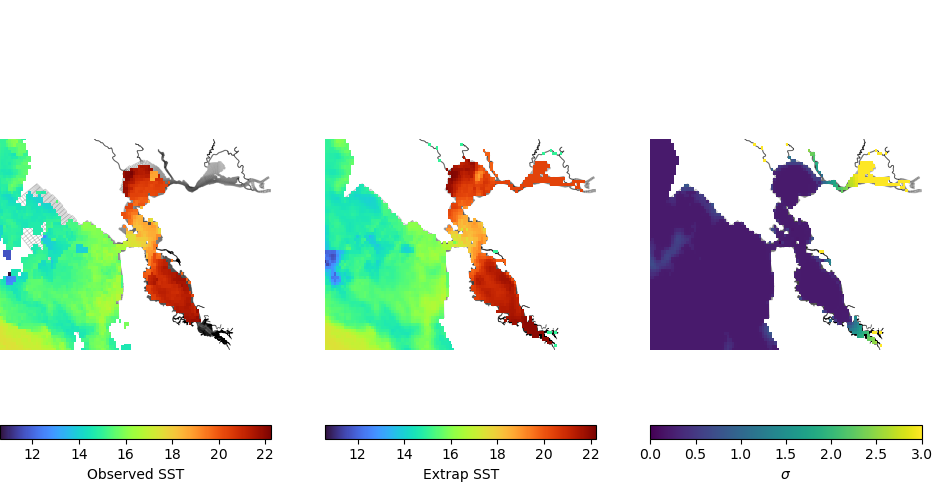

In [26]:
fig,axs=plt.subplots(1,3,figsize=(9.5,5.0))

coll0=pad_pcolormesh( ds.x, ds.y, observed, cmap='turbo',zorder=2,ax=axs[0])
coll1=pad_pcolormesh( ds.x, ds.y, est_mean, cmap='turbo',zorder=2,ax=axs[1])
coll2=pad_pcolormesh( ds.x, ds.y, np.sqrt(est_var), zorder=2,ax=axs[2])

plt.colorbar(coll0,label='Observed SST',ax=axs[0],orientation='horizontal')
plt.colorbar(coll1,label='Extrap SST',ax=axs[1],orientation='horizontal')
plt.colorbar(coll2,label='$\\sigma$',ax=axs[2],orientation='horizontal')

coll2.set_clim([0,3.0])
coll1.set_clim(coll0.get_clim())

for ax in axs:
    grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.2,zorder=1)
    ax.axis('off')
    
fig.subplots_adjust(left=0,right=0.97,top=1,bottom=0)

In [ ]:
# How does that compare to known T observations around Central Bay?


In [186]:
# Stack those up - takes a couple minutes
est_means=np.zeros_like(sst)
est_vars=np.zeros_like(sst)

for tidx in utils.progress(range(sst.shape[0])):
    observed=sst[tidx,:,:]
    est_mean,est_var = spatial_extrap(observed)
    est_means[tidx,:,:] = est_mean
    est_vars[ tidx,:,:] = est_var


INFO:utils:4234
INFO:utils:6876
INFO:utils:4/61
INFO:utils:6190
INFO:utils:5/61
INFO:utils:3091
INFO:utils:4282
INFO:utils:7/61
INFO:utils:3917
INFO:utils:4976
INFO:utils:5337
INFO:utils:5800
INFO:utils:8/61
INFO:utils:3063
INFO:utils:7267
INFO:utils:9/61
INFO:utils:6138
INFO:utils:10/61
INFO:utils:4251
INFO:utils:7275
INFO:utils:13/61
INFO:utils:3168
INFO:utils:3329
INFO:utils:4019
INFO:utils:4847
INFO:utils:5086
INFO:utils:5323
INFO:utils:5572
INFO:utils:14/61
INFO:utils:5566
INFO:utils:7543
INFO:utils:15/61
INFO:utils:3202
INFO:utils:5106
INFO:utils:6386
INFO:utils:17/61
INFO:utils:4258
INFO:utils:18/61
INFO:utils:20/61
INFO:utils:3774
INFO:utils:6868
INFO:utils:22/61
INFO:utils:5692
INFO:utils:23/61
INFO:utils:6381
INFO:utils:24/61
INFO:utils:6190
INFO:utils:27/61
INFO:utils:3425
INFO:utils:32/61
INFO:utils:4373
INFO:utils:7642
INFO:utils:33/61
INFO:utils:5831
INFO:utils:34/61
INFO:utils:5085
INFO:utils:36/61
INFO:utils:5457
INFO:utils:37/61
INFO:utils:6038
INFO:utils:38/61
INFO:ut

In [187]:
ds['extrap_spatial_mu']= ds.sst.dims, est_means
ds['extrap_spatial_var']=ds.sst.dims, est_vars

In [188]:
corr_temporal=0.9157

def combine_temporal_covariance(mus,variances, corr_temporal=0.9157, plot=False):
    """
    Similar to combine_covariance, but more generic, and operates on
    1D data.
    """
    background_mu=15.0 # or maybe some sort of global mean
    background_var = 10**2 # not really sure what this ought to be.
    
    observations=mus
    obs_variance = variances
    
    N=len(mus)
    
    rows,cols=np.meshgrid(np.arange(N),np.arange(N))
    time_offset=np.abs(rows-cols)
    
    all_corr=corr_temporal**time_offset
    
    background_mus = np.full( N, background_mu)
    
    # error covariance for the background field.
    Pb = background_var * all_corr
    
    R=np.diag(obs_variance)
    
    R_Pb_inv = np.linalg.inv(R + Pb)
    W = Pb @ R_Pb_inv
    
    results = background_mus + W@(observations - background_mus)
    
    # still need a variance estimate!
    # This is from the first section of the PDF
    Pa = R@R_Pb_inv@Pb
    
    result_vars=np.diag(Pa)
    
    if plot:
        fig,ax=plt.subplots()
        #labels=[str(i) for i in range(N)]
        #sns.heatmap(W,annot=True, xticklabels=labels, yticklabels=labels) ;
        t=np.arange(N)
        ax.errorbar( t, mus, yerr=np.sqrt(variances), label='From spatial')
        ax.errorbar( t, results, yerr=np.sqrt(result_vars), label='Analysis')
        ax.legend( loc='upper right')
    
    return results,result_vars

def extrap_time_space_covariance(tidx,corr_temporal=0.9157,water=ds.water.values):
    """
    OI-esque extrapolation in time
    """
    est_mean_time_space = np.zeros(sst.shape[1:],np.float64)
    est_var_time_space  = np.zeros(sst.shape[1:],np.float64)
    for row,col in utils.progress(np.ndindex(sst[tidx].shape)):
        if not water[row,col]:
            mu=np.nan
            v=np.nan
        else:
            analysis_mu, analysis_vars=combine_temporal_covariance(est_means[:,row,col],
                                                                   est_vars[:,row,col],
                                                                   corr_temporal=corr_temporal)
            mu=analysis_mu[tidx]
            v=analysis_vars[tidx]
        est_mean_time_space[row,col]=mu
        est_var_time_space[row,col] =v
    return est_mean_time_space,est_var_time_space

In [194]:
# Render all times to ds, save out, ready for putting on grid and final filling.
est_means_time_space=np.zeros_like(sst)
est_vars_time_space =np.zeros_like(sst)

water=ds.water.values
#corr_temporal=0.9157 # data suggests this value
corr_temporal=0.95 # testing a larger value


for row,col in utils.progress(np.ndindex(sst.shape[1:])):
    if not water[row,col]:
        mus=np.nan
        vars=np.nan
    else:
        mus,vars = combine_temporal_covariance(est_means[:,row,col],
                                                               est_vars[:,row,col],
                                                               corr_temporal=corr_temporal)
    est_means_time_space[:,row,col]=mus
    est_vars_time_space[:,row,col] =vars


In [195]:
ds['extrap_spatiotemporal_mu']=ds.sst.dims, est_means_time_space
ds['extrap_spatiotemporal_var']=ds.sst.dims, est_vars_time_space


In [191]:
ds.to_netcdf("extrapolated_avhrr.nc")

In [192]:
ds

<xarray.Dataset>
Dimensions:                    (latitude: 80, longitude: 120, time: 61,
                                wet: 2001, two: 2)
Coordinates:
    altitude                   float64 0.0
  * latitude                   (latitude) float64 37.3 37.31 ... 38.28 38.29
  * longitude                  (longitude) float64 236.7 236.7 ... 238.2 238.2
  * time                       (time) datetime64[ns] 2022-07-01T12:00:00 ... ...
    x                          (latitude, longitude) float64 4.734e+05 ... 6....
    y                          (latitude, longitude) float64 4.128e+06 ... 4....
Dimensions without coordinates: wet, two
Data variables:
    sst                        (time, latitude, longitude) float32 nan ... nan
    water                      (latitude, longitude) bool False False ... False
    water_index                (latitude, longitude) int64 -1 -1 -1 ... -1 -1 -1
    water_ll_idx               (wet, two) int64 9 107 10 104 10 ... 73 57 73 70
    extrap_spatial_mu          (time, latitude, longitude) float32 nan ... nan
    extrap_spatial_var         (time, latitude, longitude) float32 nan ... nan
    extrap_spatiotemporal_mu   (time, latitude, longitude) float32 nan ... nan
    extrap_spatiotemporal_var  (time, latitude, longitude) float32 nan ... nan
Attributes: (12/56)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Grid
    composite:                     true
    contributor_name:              NOAA NWS Monterey and NOAA CoastWatch
    contributor_role:              Source of level 2 data.
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    ...                            ...
    testOutOfDate:                 now-3days
    time_coverage_end:             2022-09-26T12:00:00Z
    time_coverage_start:           2022-09-26T12:00:00Z
    title:                         SST, NOAA POES AVHRR, LAC, 0.0125 degrees,...
    Westernmost_Easting:           215.0
    NCO:                           netCDF Operators version 4.9.0 (Homepage =...

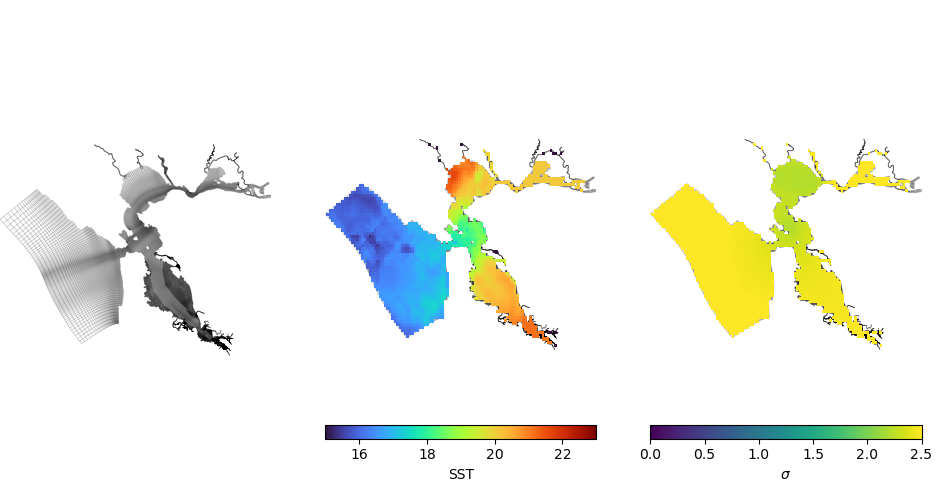

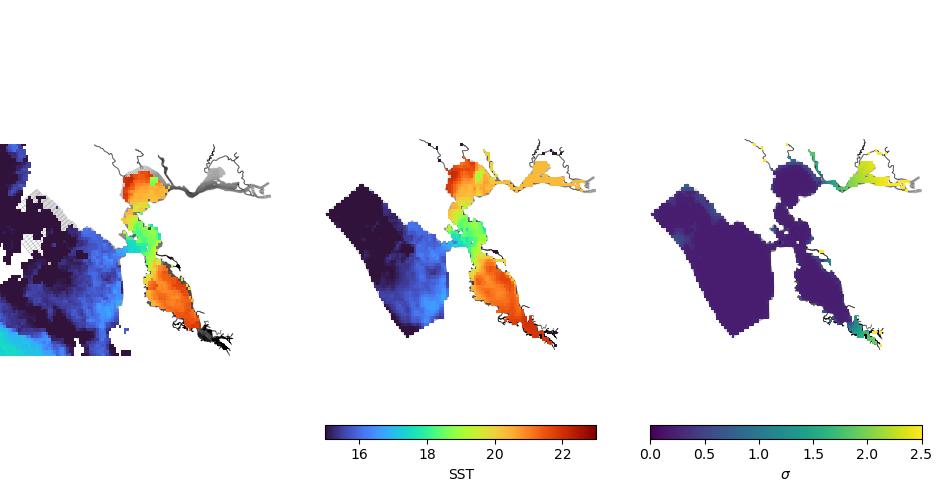

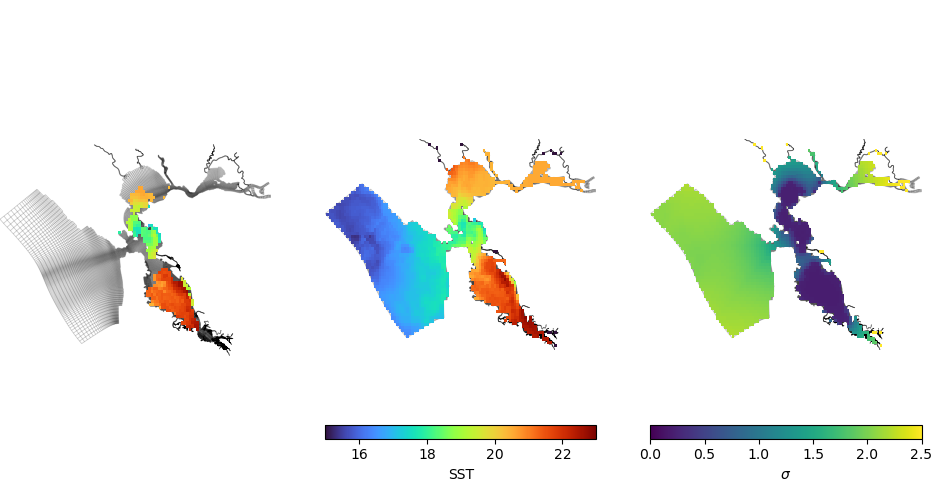

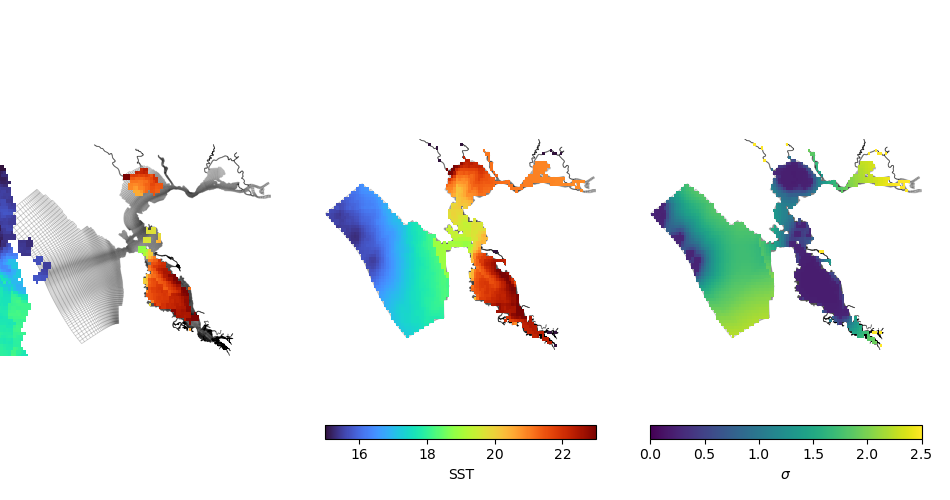

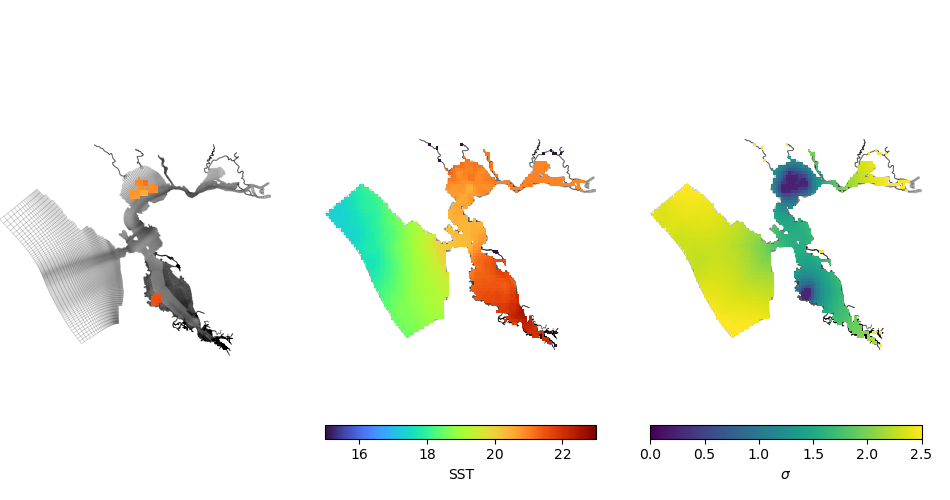

In [196]:

for tidx in range(30,35):
    #est_mean_time_space,est_var_time_space = extrap_time_space(tidx,dec_temporal=0.5)
    #est_mean_time_space,est_var_time_space = extrap_time_space_covariance(tidx)

    est_mean_time_space = est_means_time_space[tidx,:,:]
    est_var_time_space  = est_vars_time_space[tidx,:,:]
    
    # Show interpolation results:
    fig,axs=plt.subplots(1,3,figsize=(9.5,5.0))
    
    coll0=pad_pcolormesh( ds.x, ds.y, sst[tidx], cmap='turbo',zorder=2,ax=axs[0])
    coll1=pad_pcolormesh( ds.x, ds.y, est_mean_time_space, cmap='turbo',zorder=2,ax=axs[1])
    coll2=pad_pcolormesh( ds.x, ds.y, np.sqrt(est_var_time_space), zorder=2,ax=axs[2])
    
    coll0.set_clim([15,23])
    coll1.set_clim(coll0.get_clim())
    
    plt.colorbar(coll1,label='SST',ax=axs[1],orientation='horizontal')
    plt.colorbar(coll2,label='$\\sigma$',ax=axs[2],orientation='horizontal')
    
    coll2.set_clim([0,2.5])
    
    for ax in axs:
        grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.2,zorder=1)
        ax.axis('off')
        
    fig.subplots_adjust(left=0,right=0.97,top=1,bottom=0)


Estimating Correlations
==

The interpolation relies on estimates of spatial and temporal correlation.

In [ ]:
# What's a reasonable spatial decorrelation?
a_samples=np.concatenate( [ sst[:,:-1,:].ravel(), # row to row 
                            sst[:,:,:-1].ravel(), # col to col
          ])

b_samples=np.concatenate( [ sst[:,1:,:].ravel(), # row to row 
                            sst[:,:,1:].ravel(), # col to col
          ])

valid = np.isfinite(a_samples + b_samples)

sigma = np.sqrt( np.mean(((a_samples[valid] - b_samples[valid])**2) ) )
sigma**2

In [ ]:
# for the optimal interpolation approach, get this as a correlation coefficient:
rho=np.corrcoef(a_samples[valid],b_samples[valid])[0,1] # 0.997
rho

In [ ]:
# And temporal decorrelation?
a_samples=sst[:-1,:,:].ravel()
b_samples=sst[ 1:,:,:].ravel()

valid = np.isfinite(a_samples + b_samples)

sigma = np.sqrt( np.mean(((a_samples[valid] - b_samples[valid])**2) ) )
sigma**2

In [ ]:
# Likewise, get this as a correlation coefficient
np.corrcoef(a_samples[valid],b_samples[valid])[0,1]

In [ ]:
# Somewhere I had some notes on interpolating one value based on its correlation with
# a bunch of other values, including covariance among those other values.
# https://www.atmosp.physics.utoronto.ca/PHY2509/ch3.pdf
# That's not what I was using, but the gist is pretty close. Specifically, that document
# goes into the math of how 2 independent observations are more informative than two
# correlated observations.

Individual AVHRR Scenes
==

In [31]:
# From https://www.ncei.noaa.gov/data/oceans/pathfinder/Version5.3/L3C/2022/data/
url20220802030651="https://www.ncei.noaa.gov/data/oceans/pathfinder/Version5.3/L3C/2022/data/20220802030651-NCEI-L3C_GHRSST-SSTskin-AVHRR_Pathfinder-PFV5.3_NOAA19_G_2022214_night-v02.0-fv01.0.nc"
url20220802133544="https://www.ncei.noaa.gov/data/oceans/pathfinder/Version5.3/L3C/2022/data/20220802133544-NCEI-L3C_GHRSST-SSTskin-AVHRR_Pathfinder-PFV5.3_NOAA19_G_2022214_day-v02.0-fv01.0.nc"

urls=[url20220802030651,url20220802133544]
locals=["avhrr-scene-20220802030651.nc","avhrr-scene-20220802133544.nc"]

for url,local in zip(urls,locals):
    utils.download_url(url,local,on_abort='remove')


<xarray.DataArray 'time' ()>
array('2022-08-02T03:06:51.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-08-02T03:06:51
Attributes:
    standard_name:  time
    long_name:      reference time of SST file
    axis:           T
    comment:        This is the reference time of the SST file. Add sst_dtime...


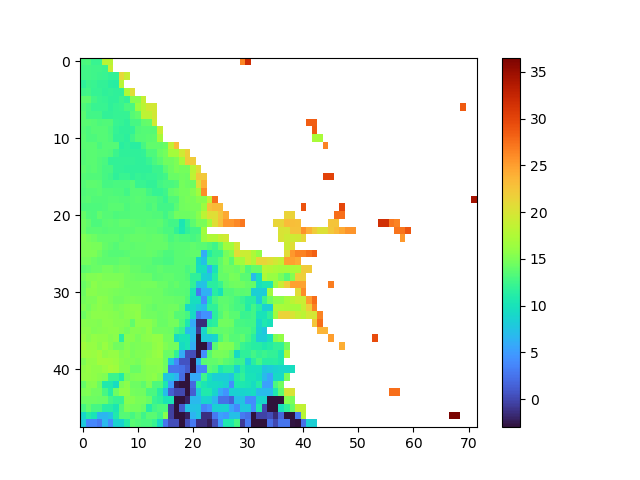

In [44]:
ds=xr.open_dataset(locals[0])
lon_sel = (ds.lon.values>-124)&(ds.lon.values<-121)
lat_sel = (ds.lat.values>37)&(ds.lat.values<39)
ds_crop = ds.isel(lon=lon_sel,lat=lat_sel,time=0)
fig,ax=plt.subplots()
img=ax.imshow(ds_crop.sea_surface_temperature-273.15,
              cmap='turbo',aspect='auto')
plt.colorbar(img,ax=ax)
print(ds_crop.time)

In [37]:
ds

<xarray.Dataset>
Dimensions:                    (time: 1, lat: 4320, lon: 8640, nv: 2)
Coordinates:
  * lat                        (lat) float32 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                        (lon) float32 -180.0 -179.9 ... 179.9 180.0
  * time                       (time) datetime64[ns] 2022-08-02T03:06:51
Dimensions without coordinates: nv
Data variables: (12/15)
    aerosol_dynamic_indicator  (time, lat, lon) float32 ...
    crs                        int32 ...
    dt_analysis                (time, lat, lon) float32 ...
    l2p_flags                  (time, lat, lon) float64 ...
    lat_bounds                 (lat, nv) float32 ...
    lon_bounds                 (lon, nv) float32 ...
    ...                         ...
    sea_surface_temperature    (time, lat, lon) float32 ...
    sses_bias                  (time, lat, lon) float32 ...
    sses_standard_deviation    (time, lat, lon) float32 ...
    sst_dtime                  (time, lat, lon) float64 ...
    time_bounds                (time, nv) datetime64[ns] ...
    wind_speed                 (time, lat, lon) float64 ...
Attributes: (12/74)
    Conventions:                             CF-1.6, ACDD-1.3
    title:                                   AVHRR Pathfinder Version 5.3 L3-...
    summary:                                 This netCDF-4 file contains sea ...
    references:                              http://pathfinder.nodc.noaa.gov ...
    institution:                             NCEI
    history:                                 smigen_both ifile=2022214.b4kd1-...
    ...                                      ...
    cdm_data_type:                           Grid
    ncei_template_version:                   NCEI_NetCDF_Grid_Template_v2.0
    program:                                 NOAA Climate Data Record (CDR) P...
    cdr_program:                             NOAA Climate Data Record Program...
    cdr_variable:                            sea_surface_temperature
    cdr_id:                                  gov.noaa.ncdc:C00983

GOES Data
==

In [47]:
# Fetch 2.5 months of data:
goes_fn = "goes_data_v00.nc"
url=("https://coastwatch.pfeg.noaa.gov"
     "/erddap/griddap/goes_west.nc?"
     "quality_level%5B(2022-07-01T00:00:00Z):1:(2022-09-15T00:00:00Z)%5D%5B(38.5):1:(37.00)%5D%5B(-123.5):1:(-121.99)%5D,"
     "sea_surface_temperature%5B(2022-07-01T00:00:00Z):1:(2022-09-15T00:00:00Z)%5D%5B(38.5):1:(37.00)%5D%5B(-123.5):1:(-121.99)%5D")

# This takes a while! 20 minutes?
utils.download_url(url,local_file=goes_fn,on_exists='pass')

In [48]:
goes_ds = xr.open_dataset(goes_fn)

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=0.328930, 15 potential interiors


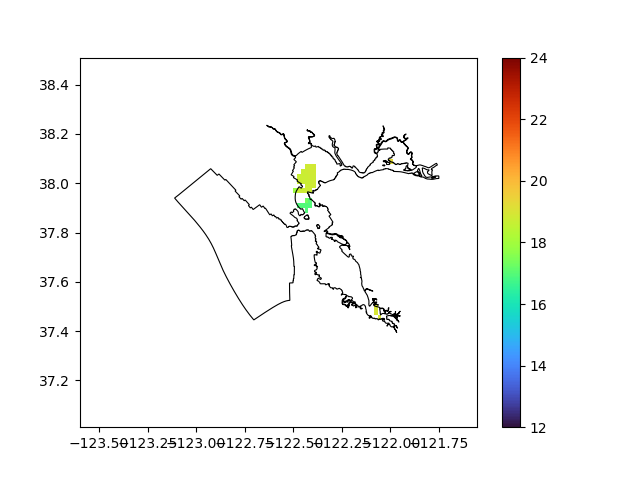

In [65]:
fig,ax=plt.subplots()
img = ax.imshow(goes_ds.sea_surface_temperature.isel(time=30), 
                interpolation='nearest', aspect='auto',
                extent=[goes_ds.longitude.min(), goes_ds.longitude.max(),
                        goes_ds.latitude.min(), goes_ds.latitude.max()],
               cmap='turbo',clim=[12,24])
plt.colorbar(img)
plot_wkb.plot_wkb(grid_ll_poly,ec='k',fc='none',lw=0.8)
ax.axis('equal')
ax.set_aspect(1./np.cos(38 * np.pi/180.0))

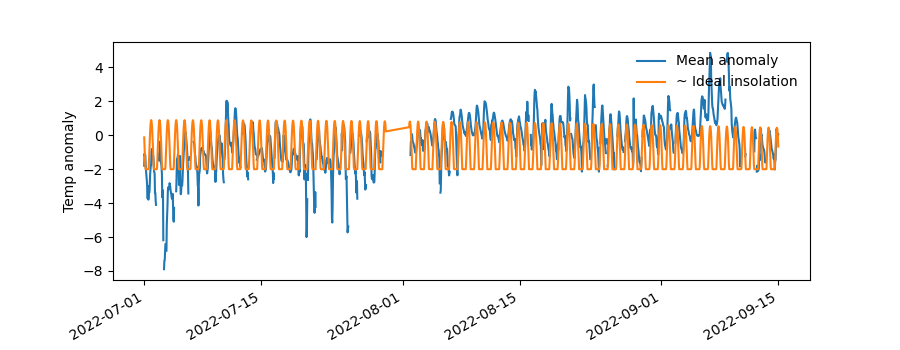

In [75]:
# Does goes show a daily cycle?
sst = goes_ds.sea_surface_temperature

# local anomaly
anom = sst - sst.mean(dim='time')
mean_anom = anom.mean(dim='latitude').mean(dim='longitude')
fig,ax=plt.subplots(figsize=(9,3.5))
ax.plot(mean_anom.time, mean_anom,label='Mean anomaly')
ax.set_ylabel('Temp anomaly')

ax.plot(mean_anom.time, 
        utils.ideal_solar_rad(Imax=3.0, t=mean_anom.time.values, lat=38.0, lon=-122) - 2.0,
        label='~ Ideal insolation')
ax.legend(loc='upper right',frameon=0)
fig.autofmt_xdate()



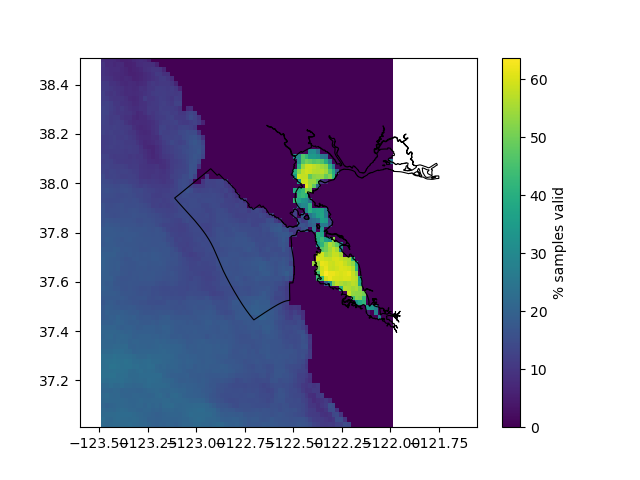

In [112]:
fig,ax=plt.subplots()
pct_valid = 100.0 * sst.notnull().sum(dim='time') / goes_ds.dims['time']
img = ax.imshow(pct_valid, 
                interpolation='nearest', aspect='auto',
                extent=[goes_ds.longitude.min(), goes_ds.longitude.max(),
                        goes_ds.latitude.min(), goes_ds.latitude.max()])
plt.colorbar(img,label='% samples valid')
plot_wkb.plot_wkb(grid_ll_poly,ec='k',fc='none',lw=0.8)
ax.axis('equal')
ax.set_aspect(1./np.cos(38 * np.pi/180.0))

In [98]:
# Grab a few pixels near Pier 17
alcatraz_usgs, pier17_usgs, smb_usgs = [
    usgs_nwis.nwis_dataset(stn,goes_ds.time.values[0],goes_ds.time.values[-1],
                           [10],cache_dir='cache')
    for stn in [
        374938122251801,
        374811122235001,
        11162765
    ]]

INFO:usgs_nwis:Fetching 374938122251801_10_2022-07-01_2022-08-01.nc
INFO:usgs_nwis:Fetching 374938122251801_10_2022-08-01_2022-09-01.nc
INFO:usgs_nwis:Fetching 374938122251801_10_2022-09-01_2022-10-01.nc
INFO:usgs_nwis:Fetching 374811122235001_10_2022-07-01_2022-08-01.nc
INFO:usgs_nwis:Fetching 374811122235001_10_2022-08-01_2022-09-01.nc
INFO:usgs_nwis:Fetching 374811122235001_10_2022-09-01_2022-10-01.nc
INFO:usgs_nwis:Fetching 11162765_10_2022-07-01_2022-08-01.nc
INFO:usgs_nwis:Fetching 11162765_10_2022-08-01_2022-09-01.nc
INFO:usgs_nwis:Fetching 11162765_10_2022-09-01_2022-10-01.nc


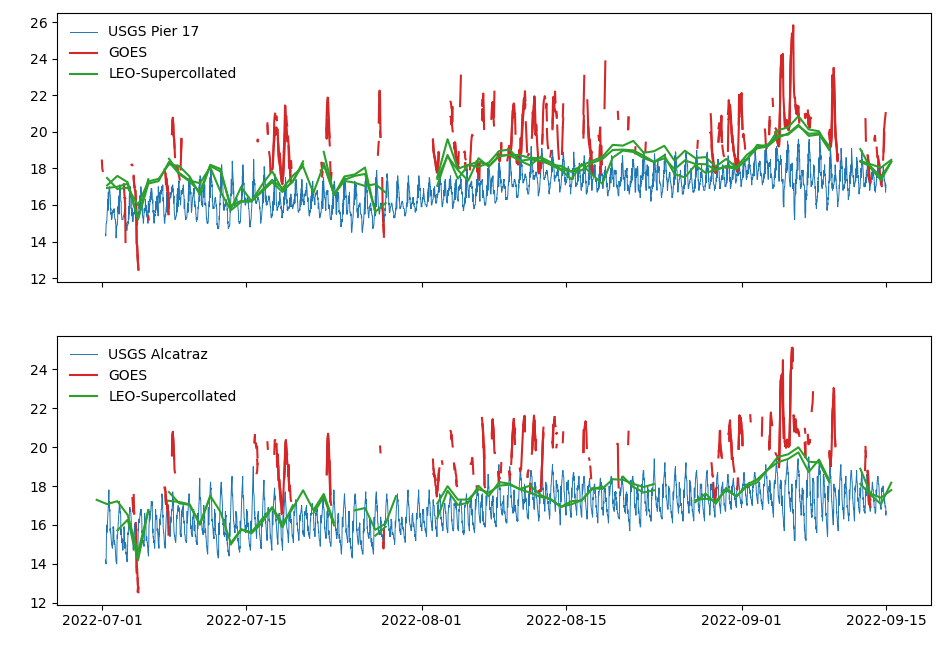

In [129]:
Pier17_utm = np.r_[553056, 4184134]
Pier17_ll  = proj_utils.mapper('EPSG:26910','WGS84')(Pier17_utm)
Alcatraz_utm = np.r_[550030,4.18629e6]
Alcatraz_ll  = proj_utils.mapper('EPSG:26910','WGS84')(Alcatraz_utm)

fig,axs = plt.subplots(2,1,sharex=True,figsize=(9.5,6.5))

if 1:
    ax=axs[0] # Pier 17
    stn_ll = Pier17_ll
    ax.plot(pier17_usgs.time, pier17_usgs.temperature_water, label='USGS Pier 17',lw=0.7)
    # careful -- goes_ds latitude is descending.
    
    lat_idx = utils.nearest(-goes_ds.latitude.values, -stn_ll[1])
    lon_idx = utils.nearest(goes_ds.longitude.values, stn_ll[0])
    for i,ll in enumerate([ (lat_idx,lon_idx),(lat_idx-1,lon_idx),(lat_idx-2,lon_idx) ]):
        ax.plot(goes_ds.time,goes_ds.sea_surface_temperature.isel(latitude=ll[0],longitude=ll[1]),
                color='tab:red',label=('GOES' if i==0 else None))

    lat_idx = utils.nearest(-supercoll_ds.latitude.values, -stn_ll[1])
    lon_idx = utils.nearest(supercoll_ds.longitude.values, stn_ll[0])
    for i,ll in enumerate([ (lat_idx,lon_idx),(lat_idx-1,lon_idx),(lat_idx-2,lon_idx) ]):
        ax.plot(supercoll_ds.time,
                supercoll_ds.sea_surface_temperature.isel(latitude=ll[0],longitude=ll[1]),
                color='tab:green',label=('LEO-Supercollated' if i==0 else None))
        
    ax.legend(loc='upper left',frameon=0)

if 1:
    stn_ll = Alcatraz_ll
    ax=axs[1] # Alcatraz
    # careful -- goes_ds latitude is descending.
    lat_idx = utils.nearest(-goes_ds.latitude.values, -stn_ll[1])
    lon_idx = utils.nearest(goes_ds.longitude.values, stn_ll[0])
    
    ax.plot(alcatraz_usgs.time, alcatraz_usgs.temperature_water, label='USGS Alcatraz',lw=0.7)
    for i,ll in enumerate([ (lat_idx,lon_idx),(lat_idx,lon_idx-1), (lat_idx,lon_idx+1) ]):
        ax.plot(goes_ds.time, goes_ds.sea_surface_temperature.isel(latitude=ll[0],longitude=ll[1]),
                color='tab:red',label=('GOES' if i==0 else None))

    lat_idx = utils.nearest(-supercoll_ds.latitude.values, -stn_ll[1])
    lon_idx = utils.nearest(supercoll_ds.longitude.values, stn_ll[0])
    for i,ll in enumerate([ (lat_idx,lon_idx),(lat_idx-1,lon_idx),(lat_idx-2,lon_idx) ]):
        ax.plot(supercoll_ds.time,
                supercoll_ds.sea_surface_temperature.isel(latitude=ll[0],longitude=ll[1]),
                color='tab:green',label=('LEO-Supercollated' if i==0 else None))
    
    ax.legend(loc='upper left',frameon=0)


fig.subplots_adjust(left=0.06,right=0.98,top=0.98,bottom=0.07)

Gridded Super-Collated
==

Some form of reanalysis / merging.

In [12]:
url = ("https://coastwatch.pfeg.noaa.gov/erddap/griddap/noaacwLEOACSPOSSTL3SCDaily.nc?"
       "sea_surface_temperature%5B(2022-07-00T00:00:00Z):1:(2022-09-15T00:00:00Z)%5D%5B(38.51):1:(37.01)%5D%5B(-123.49):1:(-121.99)%5D")
supercollated_fn="supercollated_data_v00.nc"

utils.download_url(url,local_file=supercollated_fn,on_exists='pass')

In [13]:
supercoll_ds = xr.open_dataset(supercollated_fn)
supercoll_ds

<xarray.Dataset>
Dimensions:                  (time: 78, latitude: 76, longitude: 76)
Coordinates:
  * time                     (time) datetime64[ns] 2022-06-30T12:00:00 ... 20...
  * latitude                 (latitude) float32 38.51 38.49 ... 37.03 37.01
  * longitude                (longitude) float32 -123.5 -123.5 ... -122.0 -122.0
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 ...
Attributes: (12/63)
    acknowledgement:                        Please acknowledge the use of the...
    aggregator_version:                     V1.00
    cdm_data_type:                          Grid
    col_count:                              18000
    col_start:                              0
    collation_version:                      2.11.0
    ...                                     ...
    summary:                                Sea surface temperature retrieval...
    testOutOfDate:                          now-95days
    time_coverage_end:                      2022-09-15T12:00:00Z
    time_coverage_start:                    2022-06-30T12:00:00Z
    title:                                  Sea-Surface Temperature, NOAA ACS...
    Westernmost_Easting:                    -123.49

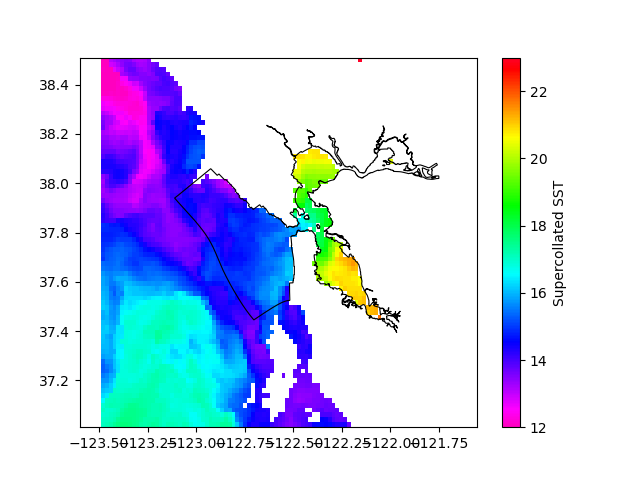

In [16]:
fig,ax=plt.subplots()
snap = supercoll_ds.sel(time=np.datetime64("2022-08-02 12:00"),method='nearest')

img = ax.imshow(snap['sea_surface_temperature'], 
                interpolation='nearest', aspect='auto',
                extent=[snap.longitude.min(), snap.longitude.max(),
                        snap.latitude.min(), snap.latitude.max()],
                cmap='gist_rainbow_r',clim=[12,23])
plt.colorbar(img,label='Supercollated SST')
plot_wkb.plot_wkb(grid_ll_poly,ec='k',fc='none',lw=0.8)
ax.axis('equal')
ax.set_aspect(1./np.cos(38 * np.pi/180.0))


In [ ]:
# Fill, warp, smooth, etc.
from stompy.spatial import field
from stompy.model import unstructured_diffuser

def get_temperature_on_grid_supercoll(grid, run_start, temp_database="supercollated_data_v00.nc"):
    # database assumed to be in lat/lon, grid in UTM.
    ds=xr.open_dataset(temp_database)
        
    tidx1=utils.nearest(ds.time.values, run_start) # both UTC. database is daily composite, centered on 12:00

    if ds.latitude.values[1] < ds.latitude.values[0]:
        lat_slice=slice(None,None,-1)
    else:
        lat_slice=slice(None)
    F = ds.sea_surface_temperature.isel(time=tidx1,latitude=lat_slice).values
    fld=field.SimpleGrid(extents=[ds.longitude.values.min(), ds.longitude.values.max(),
                                  ds.latitude.values.min(), ds.latitude.values.max()],
                         F=F)
    grid_ll = proj_utils.mapper('EPSG:26910','WGS84')(grid.cells_centroid())
    if ds.longitude.values.min()>0 and grid_ll[:,0].min()<0:
        grid_ll[:,0] += 360.0 # positive west longitude
    F_on_grid=fld.interpolate(grid_ll,interpolation='nearest')

    #  use grid diffusion to fill in gaps.
    ud = unstructured_diffuser.Diffuser(grid)
    for c in np.nonzero(np.isfinite(F_on_grid))[0]:
        ud.set_dirichlet(F_on_grid[c],cell=c)
    F_filled = ud.compute()

    return F_filled

F_filled_acspo = get_temperature_on_grid_supercoll(grid,np.datetime64("2022-08-02 12:00"))

In [45]:
def get_temperature_on_grid(grid, run_start, temp_database="extrapolated_avhrr.nc"):
    ds=xr.open_dataset(temp_database)
    
    from stompy.spatial import field

    tidx1=np.searchsorted(ds.time.values, run_start)
    
    if tidx1>0:
        tidx0=tidx1-1
        alpha = (run_start - ds.time.values[tidx0])/(ds.time.values[tidx1]-ds.time.values[tidx0])
        F = ( (1-alpha)*ds.extrap_spatiotemporal_mu.isel(time=tidx0).values
               + alpha*ds.extrap_spatiotemporal_mu.isel(time=tidx1).values)
    else:
        F = ds.extrap_spatiotemporal_mu.isel(time=tidx1).values

        
    fld=field.SimpleGrid(extents=[ds.longitude.values.min(), ds.longitude.values.max(),
                                  ds.latitude.values.min(), ds.latitude.values.max()],
                         F=F)
    grid_ll = proj_utils.mapper('EPSG:26910','WGS84')(grid.cells_centroid())
    grid_ll[:,0] += 360.0 # positive west longitude
    F_on_grid=fld(grid_ll)

    #  use grid diffusion to fill in gaps.
    ud = unstructured_diffuser.Diffuser(grid)
    for c in np.nonzero(np.isfinite(F_on_grid))[0]:
        ud.set_dirichlet(F_on_grid[c],cell=c)
    F_filled = ud.compute()

    return F_filled

F_filled_avhrr = get_temperature_on_grid(grid, np.datetime64("2022-08-02 12:00"))

Checking finite geometry


In [25]:
# Get some observations
utils.path("..")
import insitu_temperature
six.moves.reload_module(insitu_temperature)
insitu_df = insitu_temperature.all_stations()

INFO:noaa_coops:Fetching 2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Fetching 2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Fetching 2022-09-01 00:00:00 -- 2022-10-01 00:00:00
INFO:noaa_coops:Fetching 2022-10-01 00:00:00 -- 2022-11-01 00:00:00
INFO:noaa_coops:Fetching 2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Fetching 2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Fetching 2022-09-01 00:00:00 -- 2022-10-01 00:00:00
INFO:noaa_coops:Fetching 2022-10-01 00:00:00 -- 2022-11-01 00:00:00
INFO:noaa_coops:Fetching 2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Fetching 2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Fetching 2022-09-01 00:00:00 -- 2022-10-01 00:00:00
INFO:noaa_coops:Fetching 2022-10-01 00:00:00 -- 2022-11-01 00:00:00
INFO:noaa_coops:Fetching 2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Fetching 2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Fetching 2022-09-01 00:00:00 -- 

In [46]:
# Get the 24 hour range.
t_pst=insitu_df.time.values - np.timedelta64(8,'h')
snap_df=insitu_df[ (t_pst>=np.datetime64('2022-08-02 00:00')) & (t_pst<np.datetime64('2022-08-03 00:00')) ]
grped=snap_df.groupby('station')
day_summary = pd.DataFrame()
day_summary['x'] = grped.x.first()
day_summary['y'] = grped.y.first()
day_summary['Tmin'] = grped.T_degC.min()
day_summary['Tmax'] = grped.T_degC.max()
day_summary['Tmean']= grped.T_degC.mean()

# Compare to RS Field
cells = [grid.select_cells_nearest( xy ) for xy in day_summary[ ['x','y']].values] 
day_summary['Tacspo'] = F_filled_acspo[cells]
day_summary['Tavhrr'] = F_filled_avhrr[cells]

In [47]:
day_summary[ ['Tmin','Tmax','Tmean','Tacspo','Tavhrr'] ]

,Tmin,Tmax,Tmean,Tacspo,Tavhrr
station,,,,,
Alameda,19.5000,20.6000,19.923750,18.930000,20.036783
Alcatraz,15.4000,17.6000,16.546875,16.340000,17.493101
DMB,21.1000,22.0580,21.482667,21.152436,21.912418
Fort Point,15.8000,17.5000,16.454167,15.730000,17.369773
HAY,20.3060,21.4090,20.952458,20.840000,21.226958
Martinez,19.9000,21.3000,20.412083,20.182887,20.264844
Pier17,15.9000,17.7000,16.675000,17.520000,18.008308
Point Reyes,13.7000,15.4000,14.483750,14.050000,14.419342
Redwood,21.7000,22.4000,22.025000,20.803354,21.616890


In [49]:
np.sqrt( np.mean( ((day_summary['Tavhrr'] - day_summary['Tmean']).values)**2))

0.6949023391193259

In [50]:
np.sqrt( np.mean( ((day_summary['Tacspo'] - day_summary['Tmean']).values)**2))

0.6097696093480369

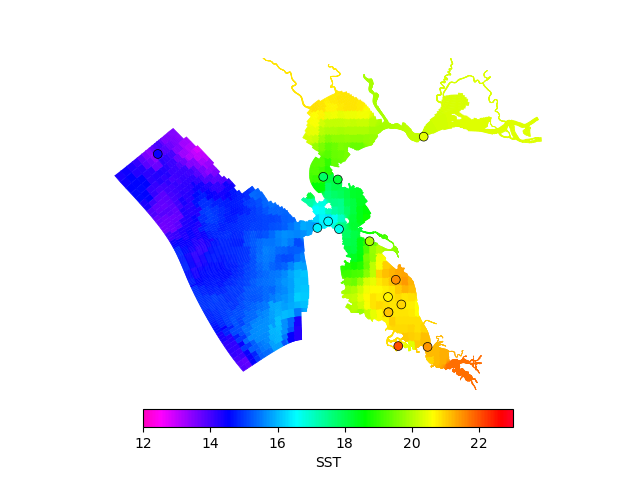

In [36]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')

kw=dict(cmap='gist_rainbow_r', clim=[12,23])

ccoll = grid.plot_cells(values=F_filled,lw=0.5,ec='face',ax=ax,**kw)

scat = ax.scatter(day_summary.x, day_summary.y, 40, day_summary.Tmean, lw=0.5, ec='k', **kw)
ax.axis('off')

plt.colorbar(ccoll,label='SST',ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)

ax.axis((507234.3739383641, 616704.2642512689, 4145527.3750866363, 4218942.827331969))

Possible Approaches
==

Most accurate satellite product might be the ACSPO LEO super-collated sub-skin temperature data.
Resolution is fine. Daily.

2022-08-02 data lines up well enough with in-situ, and has good coverage.

Could use that...

Other approach is to make more use of the monitoring data.
